In [1]:
# import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from keras.utils import plot_model 

In [4]:
# import ball data
import pickle
with open('./ball_data/X_train.pk', 'rb') as f:
    X_train = pickle.load(f)
with open('./ball_data/X_val.pk', 'rb') as f:
    X_val = pickle.load(f)
with open('./ball_data/y_train.pk', 'rb') as f:
    y_train = pickle.load(f)
with open('./ball_data/y_val.pk', 'rb') as f:
    y_val = pickle.load(f)

In [5]:
# process input images as the original model instructs
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        return None, 0, 0
    
    input_image = Image.open(image_path)
    image = Image.fromarray(np.uint8(input_image))
    image = np.array(image)
    mean_vec = np.array([103.939, 116.779, 123.68], dtype=np.float32)
    reshaped_mean_vec = mean_vec.reshape(1, 1, 3);
    im = image[:,:,::-1]
    im = im - reshaped_mean_vec

  # Pad as necessary
    cur_h, cur_w, cur_c = im.shape
    pad_h = 500 - cur_h
    pad_w = 500 - cur_w
    im = np.pad(im, pad_width=((0, pad_h), (0, pad_w), (0, 0)), mode = 'constant', constant_values = 0)
    
    return im

# This model is built on Oct.15, 2019

In [6]:
# import modules and define functions
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import numpy as np
import tensorflow as tf
from keras.engine.topology import Layer
import high_dim_filter_loader
custom_module = high_dim_filter_loader.custom_module


def _diagonal_initializer(shape, *arg, **kward):
    return np.eye(shape[0], shape[1], dtype=np.float32)


def _potts_model_initializer(shape, *arg, **kwargs):
    return -1 * _diagonal_initializer(shape)


class CrfRnnLayer(Layer):
    """ Implements the CRF-RNN layer described in:

    Conditional Random Fields as Recurrent Neural Networks,
    S. Zheng, S. Jayasumana, B. Romera-Paredes, V. Vineet, Z. Su, D. Du, C. Huang and P. Torr,
    ICCV 2015
    """

    def __init__(self, image_dims, num_classes,
                 theta_alpha, theta_beta, theta_gamma,
                 num_iterations, **kwargs):
        self.image_dims = image_dims
        self.num_classes = num_classes
        self.theta_alpha = theta_alpha
        self.theta_beta = theta_beta
        self.theta_gamma = theta_gamma
        self.num_iterations = num_iterations
        self.spatial_ker_weights = None
        self.bilateral_ker_weights = None
        self.compatibility_matrix = None
        super(CrfRnnLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Weights of the spatial kernel
        self.spatial_ker_weights = self.add_weight(name='spatial_ker_weights',
                                                   shape=(self.num_classes, self.num_classes),
                                                   initializer=_diagonal_initializer,
                                                   trainable=True)

        # Weights of the bilateral kernel
        self.bilateral_ker_weights = self.add_weight(name='bilateral_ker_weights',
                                                     shape=(self.num_classes, self.num_classes),
                                                     initializer=_diagonal_initializer,
                                                     trainable=True)

        # Compatibility matrix
        self.compatibility_matrix = self.add_weight(name='compatibility_matrix',
                                                    shape=(self.num_classes, self.num_classes),
                                                    initializer=_potts_model_initializer,
                                                    trainable=True)

        super(CrfRnnLayer, self).build(input_shape)

    def call(self, inputs):
        unaries = tf.transpose(inputs[0][0, :, :, :], perm=(2, 0, 1))
        rgb = tf.transpose(inputs[1][0, :, :, :], perm=(2, 0, 1))
#         unaries = tf.transpose(inputs[0][0, :, :, :])
#         rgb = tf.transpose(inputs[1][0, :, :, :])


        
        c, h, w = self.num_classes, self.image_dims[0], self.image_dims[1]
        all_ones = np.ones((c, h, w), dtype=np.float32)

        # Prepare filter normalization coefficients
        spatial_norm_vals = custom_module.high_dim_filter(all_ones, rgb, bilateral=False,
                                                          theta_gamma=self.theta_gamma)
        bilateral_norm_vals = custom_module.high_dim_filter(all_ones, rgb, bilateral=True,
                                                            theta_alpha=self.theta_alpha,
                                                            theta_beta=self.theta_beta)
        q_values = unaries

        for i in range(self.num_iterations):
            softmax_out = tf.nn.softmax(q_values, 0)

            # Spatial filtering
            spatial_out = custom_module.high_dim_filter(softmax_out, rgb, bilateral=False,
                                                        theta_gamma=self.theta_gamma)
            spatial_out = spatial_out / spatial_norm_vals

            # Bilateral filtering
            bilateral_out = custom_module.high_dim_filter(softmax_out, rgb, bilateral=True,
                                                          theta_alpha=self.theta_alpha,
                                                          theta_beta=self.theta_beta)
            bilateral_out = bilateral_out / bilateral_norm_vals

            # Weighting filter outputs
            message_passing = (tf.matmul(self.spatial_ker_weights,
                                         tf.reshape(spatial_out, (c, -1))) +
                               tf.matmul(self.bilateral_ker_weights,
                                         tf.reshape(bilateral_out, (c, -1))))

            # Compatibility transform
            pairwise = tf.matmul(self.compatibility_matrix, message_passing)

            # Adding unary potentials
            pairwise = tf.reshape(pairwise, (c, h, w))
            q_values = unaries - pairwise
            
            result = tf.transpose(tf.reshape(q_values, (1, c, h, w)), perm=(0, 2, 3, 1))
            print(result.shape)
        return result

    def compute_output_shape(self, input_shape):
        return input_shape


In [8]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, ZeroPadding2D, \
    Dropout, Conv2DTranspose, Cropping2D, Add, Activation
from crfrnn_layer import CrfRnnLayer
from keras import regularizers


REGULARIZERS = regularizers.l2(0.001)


def get_crfrnn_model_regular_def(num_channel):
    """ Returns Keras CRN-RNN model definition.

    Currently, only 500 x 500 images are supported. However, one can get this to
    work with different image sizes by adjusting the parameters of the Cropping2D layers
    below.
    """

    channels, height, width = 3, 500, 500

    # Input
    input_shape = (height, width, 3)
    img_input = Input(shape=input_shape)

    # Add plenty of zero padding
    x = ZeroPadding2D(padding=(100, 100))(img_input)
    
    # VGG-16 convolution block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv1_1', 
               trainable=False
              )(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2',
               trainable=False
              )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)(x)

    # VGG-16 convolution block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1',
               trainable=False
              )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2',
              trainable=False
              )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2', padding='same', trainable=False)(x)

    # VGG-16 convolution block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', 
             trainable=False)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2',
              trainable=False)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3',
             trainable=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3', padding='same', trainable=False)(x)
    pool3 = x

    # VGG-16 convolution block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1',
               trainable=False)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2',
               trainable=False)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3',
               trainable=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4', padding='same', trainable=False)(x)
    pool4 = x

    # VGG-16 convolution block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1',
               trainable=False)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2',
               trainable=False)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3',
               trainable=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5', padding='same', trainable=False)(x)

    # Fully-connected layers converted to convolution layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='valid', name='fc6',
              trainable=True)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='valid', name='fc7', trainable=True)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(num_channel, (1, 1), padding='valid', name='score-fr_2class',
              kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS, trainable=True)(x)

    # Deconvolution
    score2 = Conv2DTranspose(num_channel, (4, 4), strides=2, name='score2_2class',
                            kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS,)(x)

    # Skip connections from pool4
    score_pool4 = Conv2D(num_channel, (1, 1), name='score-pool4_2class', 
                         kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS)(pool4)
    score_pool4c = Cropping2D((5, 5))(score_pool4)
    score_fused = Add()([score2, score_pool4c])
    score4 = Conv2DTranspose(num_channel, (4, 4), strides=2, name='score4_2class',
                             kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS,
                             use_bias=False)(score_fused)

    # Skip connections from pool3
    score_pool3 = Conv2D(num_channel, (1, 1), name='score-pool3_2class',
                        kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS)(pool3)
    score_pool3c = Cropping2D((9, 9))(score_pool3)

    # Fuse things together
    score_final = Add()([score4, score_pool3c])

    # Final up-sampling and cropping
    upsample = Conv2DTranspose(num_channel, (16, 16), strides=8, name='upsample_2class', 
                               kernel_regularizer=REGULARIZERS, bias_regularizer=REGULARIZERS,
                               use_bias=False)(score_final)
    upscore = Cropping2D(((31, 37), (31, 37)))(upsample)

    output = CrfRnnLayer(image_dims=(height, width),
                         num_classes=2,
                         theta_alpha=160.,
                         theta_beta=3.,
                         theta_gamma=3.,
                         num_iterations=10,
                         name='crfrnn_2class')([upscore, img_input])
#     print(output.shape)
    # Build the model
    class_output = Activation('softmax')(output)
    model = Model(img_input, class_output, name='crfrnn_net_2class')

    return model


## Use the trained weights from the original model for layers with same names.

In [9]:
model = get_crfrnn_model_regular_def(num_channel = 2)
# load pre-trained model weights
model.load_weights('./crfrnn_keras_model.h5', by_name=True)

In [10]:
model.summary()

Model: "crfrnn_net_2class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 700, 700, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 698, 698, 64) 1792        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 698, 698, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________

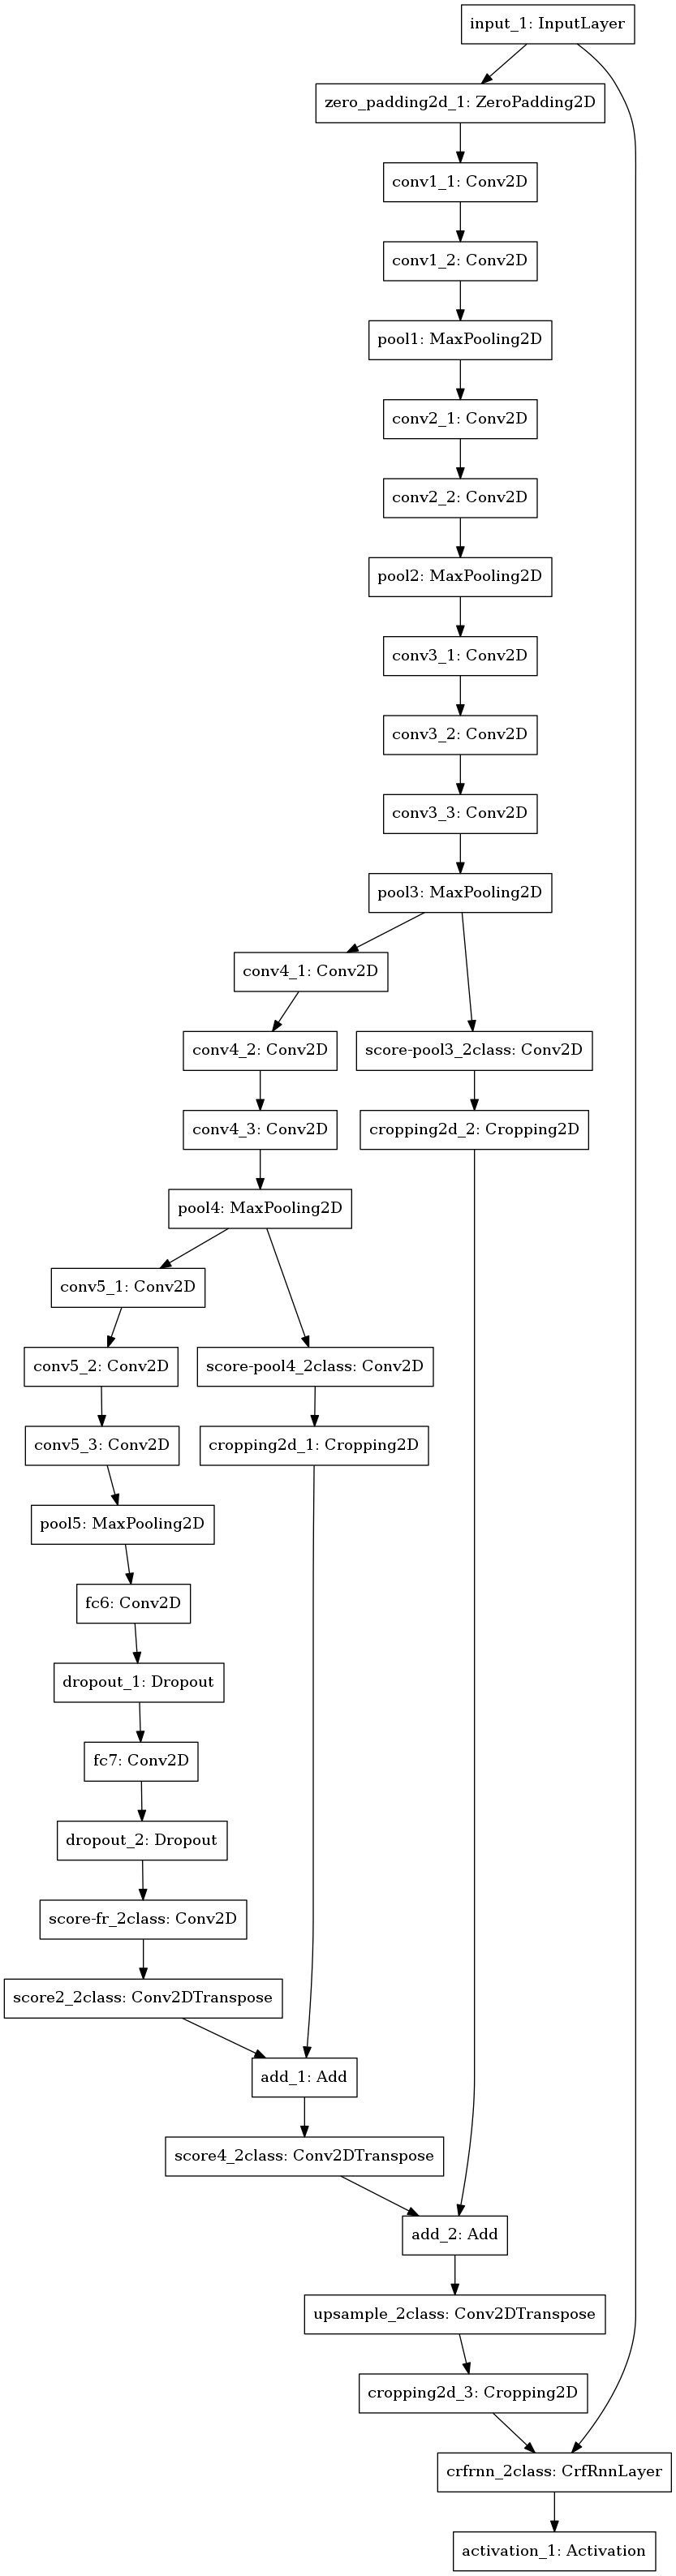

In [11]:
# visualize the model
plot_model(model)

In [7]:
import keras.backend as K
from keras.optimizers import Adam, SGD

weights = np.ones((500, 500, 2))
weights[:, :, 1] = 20
batch_size = 10
# define weighted loss function
class_weight = K.constant(np.concatenate(batch_size * [weights.reshape(1, 500, 500, 2)]))
def cross_entropy(true, pred):
    return - K.sum(K.log(1e-9+pred) * true * class_weight, axis=-1)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return ((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
model.compile(optimizer = Adam(lr = 0.01), 
              loss=cross_entropy, 
              metrics=['accuracy', f1_m])
history = model.fit(X_train, y_train,
                    epochs = 50, batch_size = batch_size, 
                    validation_data = (X_val, y_val))


Train on 40 samples, validate on 11 samples
Epoch 1/50
40/40 [==============================] - 21s 533ms/step - loss: 12.4483 - accuracy: 0.5461 - f1_m: 0.4965 - val_loss: 12.1102 - val_accuracy: 0.8225 - val_f1_m: 0.5756
Epoch 2/50
40/40 [==============================] - 14s 345ms/step - loss: 8.9518 - accuracy: 0.7471 - f1_m: 0.6792 - val_loss: 8.4843 - val_accuracy: 0.5172 - val_f1_m: 0.3510
Epoch 3/50
40/40 [==============================] - 14s 351ms/step - loss: 7.1867 - accuracy: 0.5394 - f1_m: 0.4904 - val_loss: 7.1143 - val_accuracy: 0.5736 - val_f1_m: 0.4168
Epoch 4/50
40/40 [==============================] - 14s 350ms/step - loss: 5.1510 - accuracy: 0.5449 - f1_m: 0.4954 - val_loss: 5.1924 - val_accuracy: 0.5954 - val_f1_m: 0.4208
Epoch 5/50
40/40 [==============================] - 14s 357ms/step - loss: 3.9414 - accuracy: 0.5956 - f1_m: 0.5414 - val_loss: 3.6664 - val_accuracy: 0.7127 - val_f1_m: 0.5048
Epoch 6/50
40/40 [==============================] - 14s 351ms/step -

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[10,64,698,698] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1_2/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[training/Adam/gradients/crfrnn_2class/truediv_grad/Reshape/_477]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[10,64,698,698] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1_2/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [13]:
model.save('./fine-tune-1017.h5', include_optimizer=False)

## Predict on test set

In [62]:
# calculate accuracy
1 - np.sum([i[:, :, 1].sum() for i in y_val]) / 500 / 500 / 11

0.9613872727272728

In [12]:
from PIL import Image
input_file = './55ea5a6d520c4117.jpg'
output_file = './res5.png'

import util
test = np.zeros((1,500,500,3))
test[0,:,:,:] = preprocess_image(input_file)
pred = model.predict(test, verbose=False)
segmentation = util.get_label_image(pred[0, :, :, :], 500, 500)
segmentation.save(output_file)

0.590428

[[4.8843506e-01 7.0229077e-01 2.0539666e-04 ... 9.8188764e-01
  6.3213515e-01 9.9507785e-01]
 [9.9693155e-01 1.8529759e-01 9.0904474e-02 ... 9.9637222e-01
  9.9835312e-01 6.9235110e-01]
 [8.4651500e-01 4.4773334e-01 3.8288027e-01 ... 9.1939187e-01
  7.7601385e-01 8.8870770e-01]
 ...
 [9.8352247e-01 9.9604636e-01 9.9858898e-01 ... 9.8257220e-01
  9.8881614e-01 6.7730480e-01]
 [9.4026566e-01 9.1258198e-01 8.9018941e-01 ... 8.4832454e-01
  6.7992449e-01 7.7909636e-01]
 [8.4225798e-01 9.9895680e-01 9.4159418e-01 ... 7.8423893e-01
  9.4546020e-01 8.2722217e-01]]
[[0.5115649  0.29770917 0.99979466 ... 0.01811234 0.36786488 0.00492211]
 [0.00306839 0.81470245 0.9090955  ... 0.00362774 0.00164693 0.30764896]
 [0.15348497 0.55226666 0.61711967 ... 0.08060812 0.22398613 0.11129227]
 ...
 [0.01647755 0.00395365 0.00141105 ... 0.01742778 0.01118387 0.3226952 ]
 [0.05973441 0.08741795 0.10981066 ... 0.15167549 0.32007548 0.22090359]
 [0.15774207 0.0010432  0.05840581 ... 0.21576105 0.0545

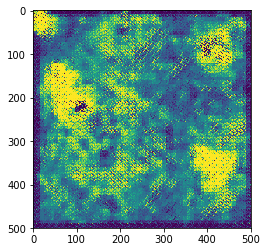

In [13]:
import matplotlib.pyplot as plt
print('''%s\n\n%s\n%s''' % (np.mean(pred[0, :, :, 0] > pred[0, :, :, 1]),
                         pred[0, :, :, 0],
                         pred[0, :, :, 1]
                         )
     )
plt.imshow(pred[0, :, :, 1])

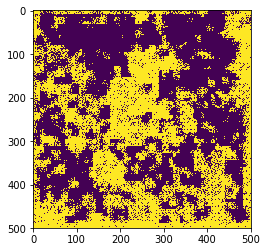

In [11]:
plt.imshow(pred[0, :, :, 0] < pred[0, :, :, 1])

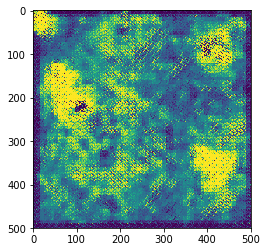

In [14]:
plt.imshow(pred[0, :, :, 1])